# Figures 2 and 6

### Load functions and packages

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import regionmask
import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

In [3]:
def convert_ipcc_to_latlon(
    data: xr.DataArray,
    mask: regionmask.Regions = regionmask.defined_regions.ar6.all,
):

    mean_data   = data.sel(metric='mean')
    strict_data = data.sel(metric='strict')
    delay_data  = data.sel(metric='delay')
    delay_mask  = data.sel(metric='delay_mask')

    unc_mask = mask.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

    # CESM1-GISTEMP 5x5
    _mean_mask   = unc_mask.copy()
    _strict_mask = unc_mask.copy()
    _delay_data_mask  = unc_mask.copy()
    _delay_mask_mask  = unc_mask.copy()

    del unc_mask

    offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
    for i in mask.numbers:
        
        _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
        _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
        _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
        _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

    regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset
    
    return regional_masked_da

## Load computed ToE data

In [4]:
toe_savedir = "../data/"

spatial_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.5x5.nc")
regional_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

all_spatial_da = xr.open_dataarray(f"{toe_savedir}/all_ToE.5x5.nc")
all_regional_da = xr.open_dataarray(f"{toe_savedir}/all_ToE.IPCCRegions.nc")

Process the all combinations data.

In [5]:
all_spatial_obs_da = all_spatial_da.drop_sel(obs="DCENT_unfilled")

strict_spatial_toe = all_spatial_obs_da.where(~np.isnan(all_spatial_obs_da),np.inf).quantile(q=0.95, dim=['realization', "model", "obs"], method='nearest')
strict_spatial_toe = strict_spatial_toe.where(~np.isinf(strict_spatial_toe),np.nan).drop_vars("quantile")

mean_spatial_toe = all_spatial_obs_da.where(~np.isnan(all_spatial_obs_da),np.inf).quantile(q=0.5, dim=['realization', "model", "obs"], method='nearest')
mean_spatial_toe = mean_spatial_toe.where(~np.isinf(mean_spatial_toe),np.nan).drop_vars("quantile")

# Compute the delay and conditional delay mask:
delay_toe = strict_spatial_toe - mean_spatial_toe # Compute the delay
delay_undef_region = np.bitwise_and(np.isnan(strict_spatial_toe), ~np.isnan(mean_spatial_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
delay_toe = xr.where(delay_undef_region, 2020 - mean_spatial_toe, delay_toe) # Apply the conditional mask

all_spatial_toes = xr.concat(
    [mean_spatial_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
    strict_spatial_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
    delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
    delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
    ],
    dim='metric',
)

all_spatial_toes = all_spatial_toes.assign_coords({'obs':'all', "model":"all"}).expand_dims(['obs',"model"])

In [6]:
all_regional_obs_da = all_regional_da.drop_sel(obs="DCENT_unfilled")

# Set nans to inf before computing quantiles, then set back to nan.
strict_regional_toe = all_regional_obs_da.where(~np.isnan(all_regional_obs_da), np.inf).quantile(q=0.95, dim=['realization', "model", "obs"], method='nearest')
strict_regional_toe = strict_regional_toe.where(~np.isinf(strict_regional_toe), np.nan).drop_vars("quantile")

mean_regional_toe = all_regional_obs_da.where(~np.isnan(all_regional_obs_da), np.inf).quantile(q=0.5, dim=['realization', "model", "obs"], method='nearest')
mean_regional_toe = mean_regional_toe.where(~np.isinf(mean_regional_toe), np.nan).drop_vars("quantile")

# Compute the delay and conditional delay mask:
delay_toe = strict_regional_toe - mean_regional_toe # Compute the delay
delay_undef_region = np.bitwise_and(np.isnan(strict_regional_toe), ~np.isnan(mean_regional_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
delay_toe = xr.where(delay_undef_region, 2020 - mean_regional_toe, delay_toe) # Apply the conditional mask

all_regional_toes = xr.concat(
    [mean_regional_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
    strict_regional_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
    delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
    delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
    ],
    dim='metric',
)

all_regional_toes = all_regional_toes.assign_coords({'obs':'all', "model":"all"}).expand_dims(['obs',"model"])

In [7]:
# Make a better land mask for the spatial 5x5 deg. regions
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask_3D_frac_approx(
    spatial_masked_da
).squeeze()
spatial_landmask = land>0.5

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [8]:
# Apply the land mask here.
mask = regionmask.defined_regions.ar6.land
regional_latlon_da = convert_ipcc_to_latlon(
    regional_masked_da,
    # mask=mask,
)

# Do for all of the data
regional_latlon_all_da = convert_ipcc_to_latlon(
    all_regional_toes,
    # mask=mask,
)

landmask = ~np.isnan(mask.mask(regional_latlon_da["lon"], regional_latlon_da["lat"],))

### Plot histograms for regional and spatial data

Show how the resolution may influence the ToE and delay using histograms.

#### CESM1- GISTEMP (land-only)

<>:229: SyntaxWarning: invalid escape sequence '\c'
<>:312: SyntaxWarning: invalid escape sequence '\c'
<>:229: SyntaxWarning: invalid escape sequence '\c'
<>:312: SyntaxWarning: invalid escape sequence '\c'
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_61938/811839438.py:229: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_61938/811839438.py:312: SyntaxWarning: invalid escape sequence '\c'
  label='$5^{\circ}$x$5^{\circ}$ Regions',
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_61938/811839438.py:8: UserWarning: `natural_earth_v5_0_0.ocean_basins_50` does not quite extend to 180°E - it's recommended to use `natural_earth_v5_1_2.ocean_basins_50` instead. See https://github.com/regionmask/regionmask/issues/410.
  ocean = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50


Regional Median fraction emerge: 0.917
Regional Strict fraction emerge: 0.917
5x5 deg. Median fraction emerge: 0.928
5x5 deg. Strict fraction emerge: 0.886
Regional fraction delay >5years: 0.523
Regional fraction delay >10years: 0.352
Regional fraction delay >15years: 0.205
Regional fraction delay >20years: 0.156
5x5 deg. fraction delay >5years: 0.661
5x5 deg. fraction delay >10years: 0.366
5x5 deg. fraction delay >15years: 0.244
5x5 deg. fraction delay >20years: 0.166


Text(-0.1, 1.08, 'c.')

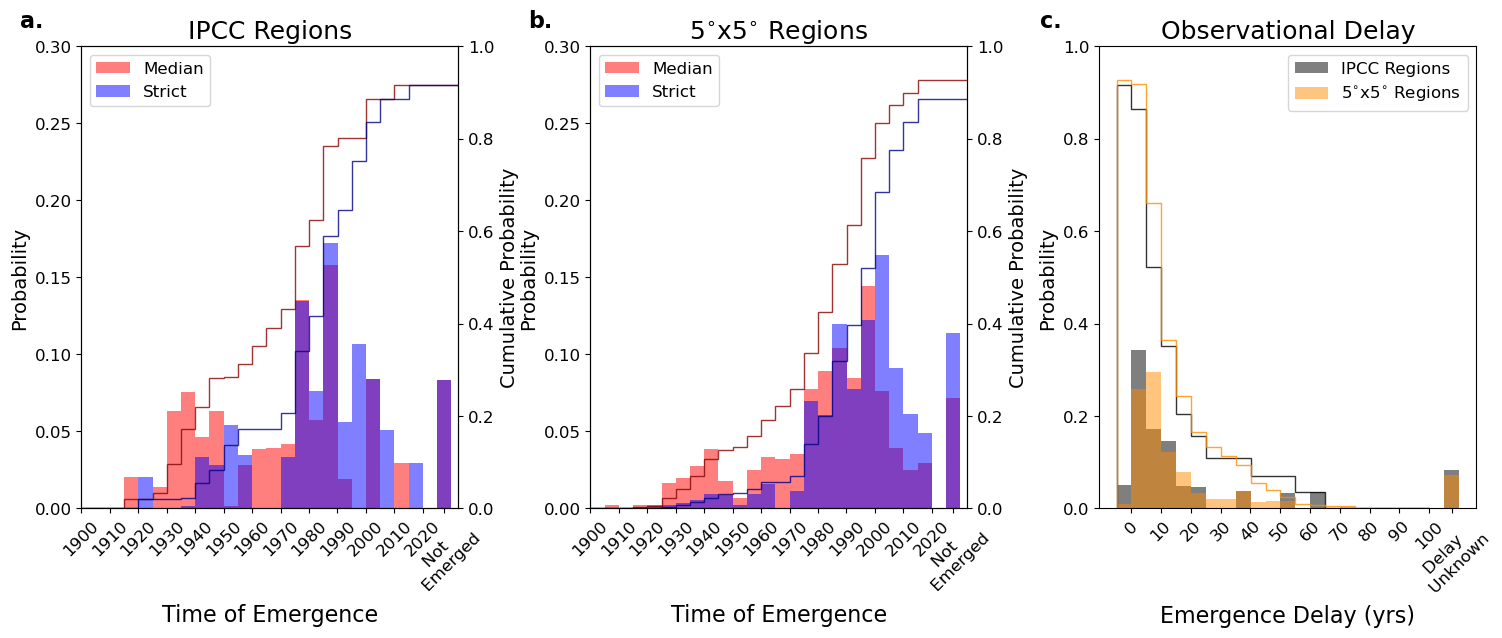

In [9]:
# Go model agnostic, but remove OBS-LE for methodological reasons.

regional_data_latloned = regional_latlon_da.sel(obs="GISTEMP_5x5", model="CESM1")
spatial_data  = spatial_masked_da.sel(obs="GISTEMP_5x5", model="CESM1")

# Set up masks!
land  = regionmask.defined_regions.natural_earth_v5_0_0.land_110
ocean = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50

# Pick your mask
mask = land #None, land, ocean

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

startyear = 1900

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon')

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

# Set nans to the different masking values out of the normal range (1900, 2020)
mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, nan_mask_value2+5, 5)
xticks = np.arange(startyear, nan_mask_value2+5, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

# Set up mask with the data dimensions and do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=mean_data_subset_stack,
    bins=bins,
    color='red',alpha=0.5,label='Median',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=mean_data_subset_stack2,
    bins=bins,
    color='darkred',alpha=0.8,label='Median ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Median fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=strict_data_subset_stack,
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=strict_data_subset_stack2,
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, 2041, 5)
# xticks = np.arange(startyear, 2036, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(mean_data_subset_stack),
    bins=bins,
    color='red',alpha=0.5,label='Median',
    density=False,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(mean_data_subset_stack2),
    bins=bins,
    color='darkred',alpha=0.8,label='Median ToE Cumulative',
    density=True,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Median fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(strict_data_subset_stack),
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(strict_data_subset_stack2),
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0, 1.1, 0.2))

# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

longest_delay = 100
delay_shift = 10
nan_mask_value = longest_delay + delay_shift
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

bins = np.arange(-4.9, longest_delay + delay_shift + 1, 5)
reverse_bins = np.arange(-4.9, longest_delay + 1, 5)

xticks = list(np.arange(0, longest_delay + 1, 10))
xticks.append(nan_mask_value - 2.5)
xticklabels = list(np.arange(0, longest_delay + 1, 10))
xticklabels.append('Delay \n Unknown')
yticks = np.arange(0, 0.14, 0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(regional_data_subset.lon,regional_data_subset.lat)).broadcast_like(regional_data_subset)
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    regional_data_weights_stack = regional_data_weights_stack[mask_broad_stack]
    regional_data_subset_stack  = regional_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=bins,
    color='black',alpha=0.5,
    label='IPCC Regions',
    density=False,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='black',alpha=0.8,
    # label='Regional (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >10years: %.3f' % _n[3])
print('Regional fraction delay >15years: %.3f' % _n[4])
print('Regional fraction delay >20years: %.3f' % _n[5])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(spatial_data_subset.lon,spatial_data_subset.lat)).broadcast_like(spatial_data_subset)
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    spatial_data_weights_stack = spatial_data_weights_stack[mask_broad_stack]
    spatial_data_subset_stack  = spatial_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=bins,
    color='darkorange',alpha=0.5,
    label='$5^{\circ}$x$5^{\circ}$ Regions',
    density=False,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='darkorange',alpha=0.8,
    # label='Spatial (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >10years: %.3f' % _n[3])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])
print('5x5 deg. fraction delay >20years: %.3f' % _n[5])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Observational Delay',fontsize=18)
ax.legend(fontsize=12)

# Add subplot labels
axs[0].text(-0.1, 1.08, 'a.', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axs[1].text(-0.1, 1.08, 'b.', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axs[2].text(-0.1, 1.08, 'c.', transform=axs[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

In [10]:
to_png(
    file=fig,
    filename='ToE_histogram_statistics_movingstartyear_land_cesm1gistemp',
    loc="../figures/",
    dpi=300,
    ext='pdf',
    bbox_inches='tight',
)

Conservative approach with 1600 ToE values for each region.

<>:228: SyntaxWarning: invalid escape sequence '\c'
<>:315: SyntaxWarning: invalid escape sequence '\c'
<>:228: SyntaxWarning: invalid escape sequence '\c'
<>:315: SyntaxWarning: invalid escape sequence '\c'
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_61938/981383733.py:228: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_61938/981383733.py:315: SyntaxWarning: invalid escape sequence '\c'
  label='$5^{\circ}$x$5^{\circ}$ Regions',


Regional Median fraction emerge: 0.917
Regional Strict fraction emerge: 0.917
5x5 deg. Median fraction emerge: 0.921
5x5 deg. Strict fraction emerge: 0.738
Regional fraction delay >5years: 0.849
Regional fraction delay >10years: 0.751
Regional fraction delay >15years: 0.494
Regional fraction delay >20years: 0.353
5x5 deg. fraction delay >5years: 0.870
5x5 deg. fraction delay >10years: 0.676
5x5 deg. fraction delay >15years: 0.430
5x5 deg. fraction delay >20years: 0.296


Text(-0.1, 1.08, 'c.')

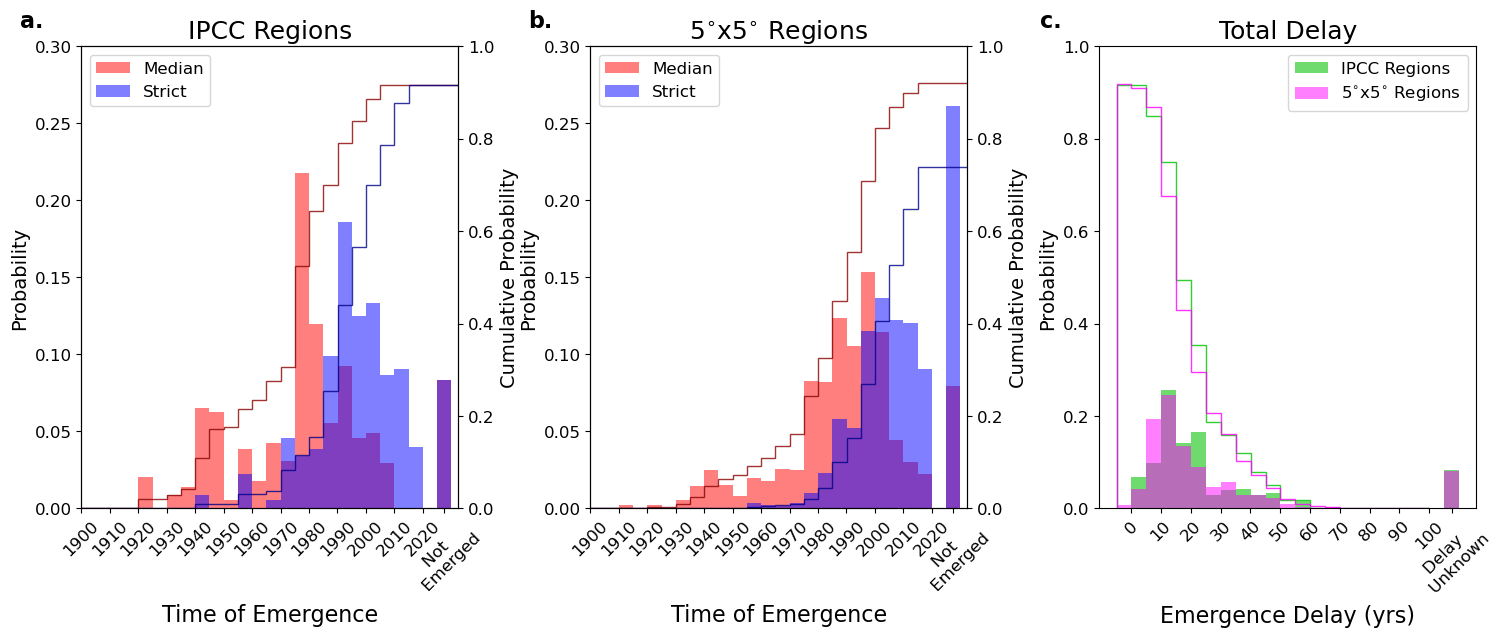

In [11]:
# Go model agnostic, but remove OBS-LE for methodological reasons.
regional_data_latloned = regional_latlon_all_da
spatial_data  = all_spatial_toes

# Set up masks!
land  = regionmask.defined_regions.natural_earth_v5_0_0.land_110
ocean = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50

# Pick your mask
mask = land #None, land, ocean

fig,axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.35)
axs = axs.flat

startyear = 1900

# Start plot 1
ax = axs[0]
data = regional_data_latloned
zstack_vars = ('lat','lon','model','obs')

mean_data_subset0    = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

nan_mask_value  = 2027.5
nan_mask_value2 = 2036

# Set nans to the different masking values out of the normal range (1900, 2020)
mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, nan_mask_value2+5, 5)
xticks = np.arange(startyear, nan_mask_value2+5, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars).values
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars).values
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars).values

# Set up mask with the data dimensions and do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=mean_data_subset_stack,
    bins=bins,
    color='red',alpha=0.5,label='Median',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=mean_data_subset_stack2,
    bins=bins,
    color='darkred',alpha=0.8,label='Median ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Median fraction emerge: %.3f' % _n[-2])

strict_data_weights,_     = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars).values
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars).values
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars).values

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=strict_data_subset_stack,
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=strict_data_weights_stack/strict_data_weights_stack.sum(),
)

_n,_bins,_pathes = ax2.hist(
    x=strict_data_subset_stack2,
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=mean_data_weights_stack/mean_data_weights_stack.sum(),
    histtype="step",        
    cumulative=True
)

print('Regional Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('IPCC Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0,1.1,0.2))

# Subplot 2
ax = axs[1]
data = spatial_data

mean_data_subset0 = copy.copy(data.sel(metric='mean'))
strict_data_subset0  = copy.copy(data.sel(metric='strict'))

mean_data_subset    = xr.where(np.isnan(mean_data_subset0),nan_mask_value,mean_data_subset0)
mean_data_subset2   = xr.where(np.isnan(mean_data_subset0),nan_mask_value2,mean_data_subset0)
strict_data_subset  = xr.where(np.isnan(strict_data_subset0),nan_mask_value,strict_data_subset0)
strict_data_subset2 = xr.where(np.isnan(strict_data_subset0),nan_mask_value2,strict_data_subset0)

ax2 = ax.twinx()

bins = np.arange(startyear + 0.01, 2041, 5)
# xticks = np.arange(startyear, 2036, 5)
xticks = list(np.arange(startyear, 2021, 10))
xticks.append(nan_mask_value)
xticklabels = list(np.arange(startyear, 2021, 10))
xticklabels.append('Not \n Emerged')
yticks = np.arange(0, 0.31, 0.05)

# This should work to do the weighting but it doesn't!
mean_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(mean_data_subset.lat)),mean_data_subset)
mean_data_weights_stack = mean_data_weights.stack(z=zstack_vars)
mean_data_subset_stack  = mean_data_subset.stack(z=zstack_vars)
mean_data_subset_stack2 = mean_data_subset2.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(data.lon,data.lat)).broadcast_like(data.isel(metric=0))
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    mean_data_weights_stack = mean_data_weights_stack[mask_broad_stack]
    mean_data_subset_stack = mean_data_subset_stack[mask_broad_stack]
    mean_data_subset_stack2 = mean_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(mean_data_subset_stack),
    bins=bins,
    color='red',alpha=0.5,label='Median',
    density=False,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(mean_data_subset_stack2),
    bins=bins,
    color='darkred',alpha=0.8,label='Median ToE Cumulative',
    density=True,
    weights=np.array(mean_data_weights_stack/mean_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Median fraction emerge: %.3f' % _n[-2])

strict_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(strict_data_subset.lat)),strict_data_subset)
strict_data_weights_stack = strict_data_weights.stack(z=zstack_vars)
strict_data_subset_stack  = strict_data_subset.stack(z=zstack_vars)
strict_data_subset_stack2 = strict_data_subset2.stack(z=zstack_vars)

# Do masking on the stacked data (cannot do boolean indexing over 4 dimensions)
if (not mask is None):
    strict_data_weights_stack = strict_data_weights_stack[mask_broad_stack]
    strict_data_subset_stack = strict_data_subset_stack[mask_broad_stack]
    strict_data_subset_stack2 = strict_data_subset_stack2[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(strict_data_subset_stack),
    bins=bins,
    color='blue',alpha=0.5,label='Strict',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax2.hist(
    x=np.array(strict_data_subset_stack2),
    bins=bins,
    color='darkblue',alpha=0.8,label='Strict ToE Cumulative',
    density=False,
    weights=np.array(strict_data_weights_stack/strict_data_weights_stack.sum()),
    histtype="step",        
    cumulative=True
)

print('5x5 deg. Strict fraction emerge: %.3f' % _n[-2])

# Ax1 set-up
ax.set_xticks(xticks)
ax.set_xlim(startyear, 2032.5)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Time of Emergence',fontsize=16)

ax.set_yticks(yticks)
ax.set_ylabel('Probability',fontsize=14)

ax.set_title('$5^{\circ}$x$5^{\circ}$ Regions',fontsize=18)
ax.legend(fontsize=12,loc='upper left')

# Ax2 set-up
ax2.tick_params(axis='both',labelsize=12)

ax2.set_ylim(0,1.0)
ax2.set_ylabel('Cumulative Probability',fontsize=14)
_ = ax2.set_yticks(np.arange(0, 1.1, 0.2))


# Subplot 3
ax = axs[2]

metric = 'delay'
regional_data_subset = copy.copy(regional_data_latloned.sel(metric=metric))
spatial_data_subset  = copy.copy(spatial_data.sel(metric=metric))

longest_delay = 100
delay_shift = 10
nan_mask_value = longest_delay + delay_shift
regional_data_subset = xr.where(np.isnan(regional_data_subset),nan_mask_value,regional_data_subset)
spatial_data_subset = xr.where(np.isnan(spatial_data_subset),nan_mask_value,spatial_data_subset)

bins = np.arange(-4.9, longest_delay + delay_shift + 1, 5)
reverse_bins = np.arange(-4.9, longest_delay + 1, 5)

xticks = list(np.arange(0, longest_delay + 1, 10))
xticks.append(nan_mask_value - 2.5)
xticklabels = list(np.arange(0, longest_delay + 1, 10))
xticklabels.append('Delay \n Unknown')
yticks = np.arange(0, 0.14, 0.01)

regional_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(regional_data_subset.lat)),regional_data_subset)
regional_data_weights_stack = regional_data_weights.stack(z=zstack_vars)
regional_data_subset_stack  = regional_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(regional_data_subset.lon,regional_data_subset.lat)).broadcast_like(regional_data_subset)
    mask_broad_stack        = mask_broad.stack(z=zstack_vars)

    regional_data_weights_stack = regional_data_weights_stack[mask_broad_stack]
    regional_data_subset_stack  = regional_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=bins,
    color='limegreen',alpha=0.7,
    # color='black',alpha=0.5,
    label='IPCC Regions',
    density=False,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(regional_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='limegreen',alpha=1,
    # color='black',alpha=0.8,
    # label='Regional (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(regional_data_weights_stack/regional_data_weights_stack.sum()),
)

print('Regional fraction delay >5years: %.3f' % _n[2])
print('Regional fraction delay >10years: %.3f' % _n[3])
print('Regional fraction delay >15years: %.3f' % _n[4])
print('Regional fraction delay >20years: %.3f' % _n[5])

spatial_data_weights,_ = xr.broadcast(np.cos(np.deg2rad(spatial_data_subset.lat)),spatial_data_subset)
spatial_data_weights_stack = spatial_data_weights.stack(z=zstack_vars)
spatial_data_subset_stack  = spatial_data_subset.stack(z=zstack_vars)

if (not mask is None):
    mask_broad = np.isfinite(mask.mask(spatial_data_subset.lon,spatial_data_subset.lat)).broadcast_like(spatial_data_subset)
    mask_broad_stack        = mask_broad.stack(z=('lat','lon','model','obs'))

    spatial_data_weights_stack = spatial_data_weights_stack[mask_broad_stack]
    spatial_data_subset_stack  = spatial_data_subset_stack[mask_broad_stack]

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=bins,
    color='magenta',alpha=0.5,
    # color='darkorange',alpha=0.5,
    label='$5^{\circ}$x$5^{\circ}$ Regions',
    density=False,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

_n,_bins,_pathes = ax.hist(
    x=np.array(spatial_data_subset_stack),
    bins=reverse_bins,
    histtype="step",
    color='magenta',alpha=0.8,
    # color='darkorange',alpha=0.8,
    # label='Spatial (reverse cumulative)',
    density=False,
    cumulative=-1,
    weights=np.array(spatial_data_weights_stack/spatial_data_weights_stack.sum()),
)

print('5x5 deg. fraction delay >5years: %.3f' % _n[2])
print('5x5 deg. fraction delay >10years: %.3f' % _n[3])
print('5x5 deg. fraction delay >15years: %.3f' % _n[4])
print('5x5 deg. fraction delay >20years: %.3f' % _n[5])

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Emergence Delay (yrs)',fontsize=16)

ax.set_ylabel('Probability',fontsize=14)
ax.set_ylim(0,1.0)

ax.set_title('Total Delay',fontsize=18)
ax.legend(fontsize=12)

# Add subplot labels
axs[0].text(-0.1, 1.08, 'a.', transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axs[1].text(-0.1, 1.08, 'b.', transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
axs[2].text(-0.1, 1.08, 'c.', transform=axs[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

In [12]:
to_png(
    file=fig,
    filename='ToE_histogram_statistics_movingstartyear_allconservative_land',
    loc="../figures/",
    dpi=300,
    ext='pdf',
    bbox_inches='tight',
)